Here are some examples for how to use some of the functionality of Muldoon.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from numpy.random import normal

from muldoon.met_timeseries import MetTimeseries
from muldoon.utils import modified_lorentzian, fit_vortex, write_out_plot_data

In [14]:
# Create time-series
time = np.linspace(-10, 10, 1000)
baseline = 0.
slope = 1.
t0 = 0.
DeltaP = 1.
Gamma = 0.5

right_answer = np.array([baseline, slope, t0, DeltaP, Gamma])

profile = modified_lorentzian(time, baseline, slope, t0, DeltaP, Gamma) + normal(scale=slope/20., size=len(time))
mt = MetTimeseries(time, profile)

0.05560476253833451
True


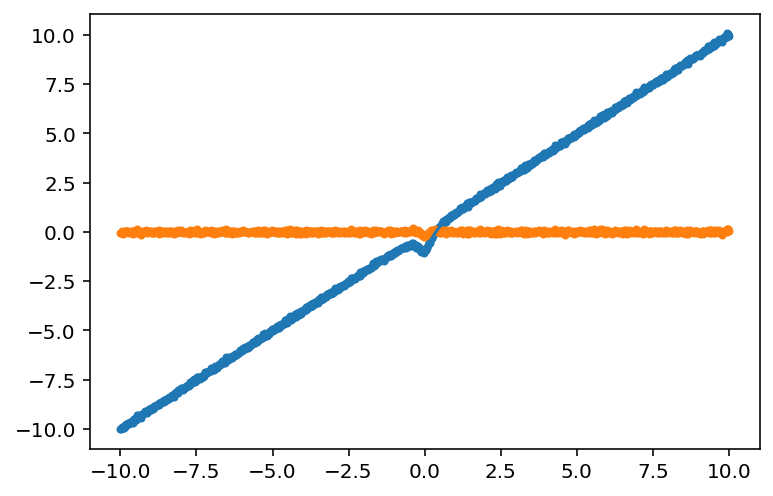

In [3]:
# Detrend
window_size = Gamma
detrended_pressure = mt.detrend_pressure_timeseries(window_size)
print(np.std(mt.detrended_pressure))
print(np.isclose(np.std(mt.detrended_pressure), 0.1, atol=0.1))

plt.scatter(mt.time, mt.pressure, marker='.')
plt.scatter(mt.time, mt.detrended_pressure, marker='.')
plt.plot(mt.time, mt.pressure_trend)

In [4]:
# Test time-series write-out
write_str = write_out_plot_data(mt.time, mt.pressure, yerr=np.std(mt.pressure)*np.ones_like(mt.pressure),
                                x_label="Time", y_label="Pressure", test_mode=True)
print(write_str);

# Time, Pressure, Pressure_err
-10, -9.99843, 5.78034
-9.97998, -9.98444, 5.78034
-9.95996, -9.88552, 5.78034
-9.93994, -9.97165, 5.78034
-9.91992, -9.96103, 5.78034
-9.8999, -9.96563, 5.78034
-9.87988, -9.9418, 5.78034
-9.85986, -9.82644, 5.78034
-9.83984, -9.88843, 5.78034
-9.81982, -9.79384, 5.78034
-9.7998, -9.76472, 5.78034
-9.77978, -9.72868, 5.78034
-9.75976, -9.71487, 5.78034
-9.73974, -9.73376, 5.78034
-9.71972, -9.76823, 5.78034
-9.6997, -9.68654, 5.78034
-9.67968, -9.66274, 5.78034
-9.65966, -9.63172, 5.78034
-9.63964, -9.66907, 5.78034
-9.61962, -9.59778, 5.78034
-9.5996, -9.54056, 5.78034
-9.57958, -9.68312, 5.78034
-9.55956, -9.51866, 5.78034
-9.53954, -9.48982, 5.78034
-9.51952, -9.5479, 5.78034
-9.4995, -9.52821, 5.78034
-9.47948, -9.44543, 5.78034
-9.45946, -9.32018, 5.78034
-9.43944, -9.42399, 5.78034
-9.41942, -9.44343, 5.78034
-9.3994, -9.31735, 5.78034
-9.37938, -9.37578, 5.78034
-9.35936, -9.36102, 5.78034
-9.33934, -9.36669, 5.78034
-9.31932, -9.44535, 5.78034
-9

9.587411228183012 0.010010010010010006 0.040040040040040026
0.010010010010010006


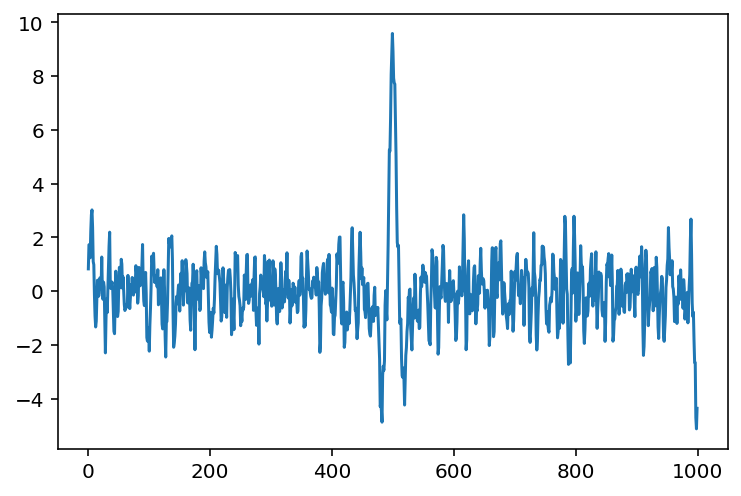

In [5]:
# plt.plot(mt.time, profile)
conv = mt.apply_lorentzian_matched_filter(2.*mt.sampling, 1./np.pi)
mx_ind = np.argmax(mt.convolution)

print(mt.convolution[mx_ind], np.abs(mt.time[mx_ind]), 2.*mt.sampling)
# plt.plot(mt.time, mt.convolution)
# plt.plot(mt.time, profile)
plt.plot(mt.convolution)
# Make sure convolution returns a strong peak at the right time
print((np.abs(mt.time[mx_ind])))

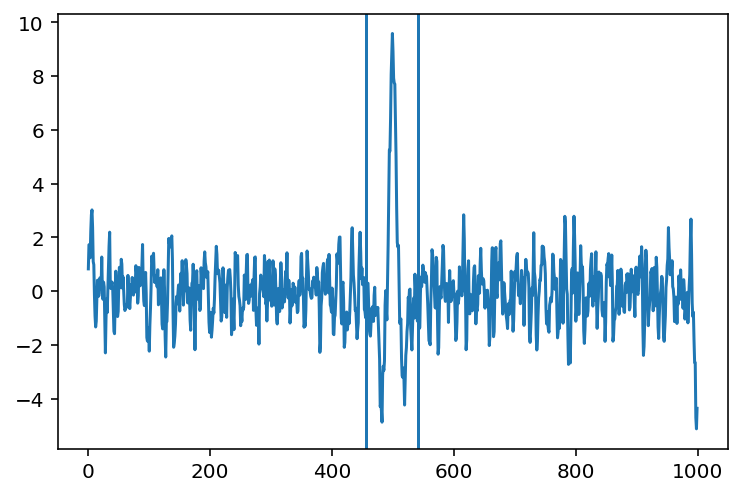

In [6]:
# Test find_vortices - Set the threshold very low to make sure the right peak is actually at the top of the list
vortices = mt.find_vortices(detection_threshold=2)
plt.plot(mt.convolution)
plt.axvline(mt.peak_indices[0] - 3.*mt.peak_widths[0])
plt.axvline(mt.peak_indices[0] + 3.*mt.peak_widths[0])

# Make sure the max peak in the convolution is the right one
assert(mt.time[mt.peak_indices[0]] < Gamma)

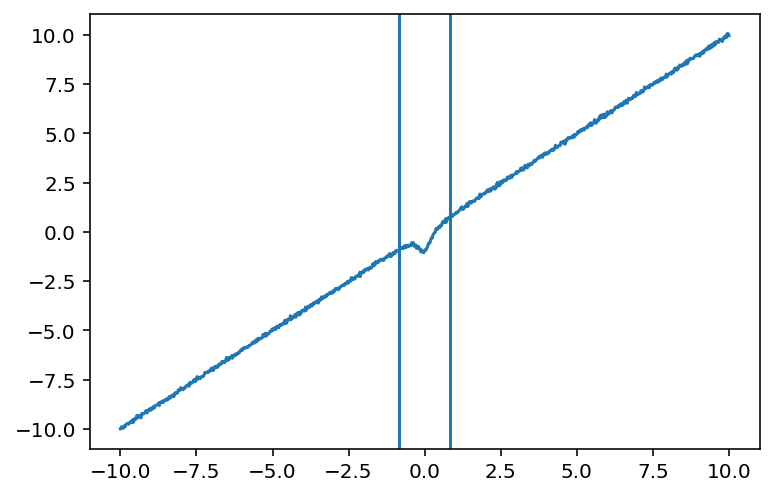

In [7]:
# Test find_vortices
vortices = mt.find_vortices(detection_threshold=7)
plt.plot(mt.time, mt.pressure)
plt.axvline(mt.time[mt.peak_indices[0] - 3*int(mt.peak_widths[0])])
plt.axvline(mt.time[mt.peak_indices[0] + 3*int(mt.peak_widths[0])])

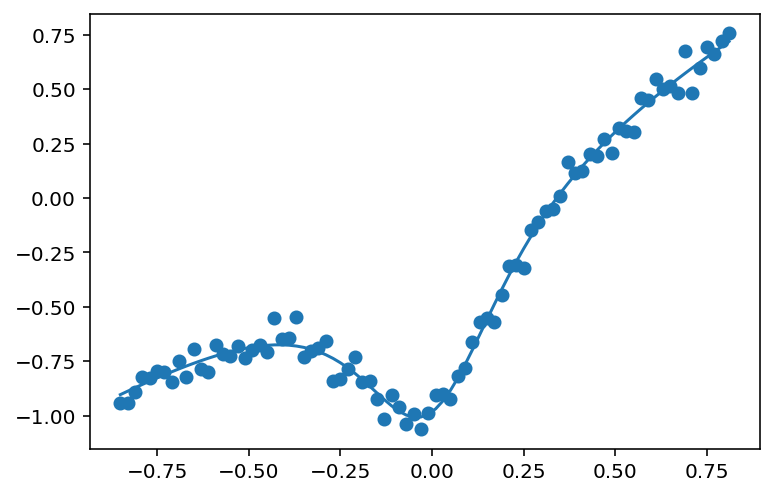

In [8]:
plt.scatter(vortices[0]["time"], vortices[0]["pressure"])

# Test vortex fit
old_popt, old_unc = fit_vortex(vortices[0], [0., 1., 0., 1., 0.01], 
                          [[-1, -1, np.min(vortices[0]["time"]), 0, 0],
                           [1, 1, np.max(vortices[0]["time"]), 2, 1]], sigma=vortices[0]["pressure_scatter"])
assert(np.max(np.abs(old_popt - right_answer)/old_unc) < 3.)

plt.plot(vortices[0]["time"], modified_lorentzian(vortices[0]["time"], *old_popt))

In [17]:
init_params = mt._determine_init_params(vortices[0])
bounds = mt._determine_bounds(vortices[0], init_params)
popt, unc = fit_vortex(vortices[0], init_params, bounds, sigma=vortices[0]["pressure_scatter"])
assert(np.max(np.abs(popt - right_answer)/unc) < 3.)

print(np.max(np.abs(popt - right_answer)/unc))

1.9193484450591438


In [150]:
# Test fit all vortices

# Create time-series
time = np.linspace(-10, 10, 1000)
baseline = 0.
slope = 1.
t0 = 0.
DeltaP = 1.
Gamma = 0.5

right_answer = np.array([baseline, slope, t0, DeltaP, Gamma])

profile = modified_lorentzian(time, baseline, slope, t0, DeltaP, Gamma) + normal(scale=slope/20., size=len(time))
mt = MetTimeseries(time, profile)
window_size = Gamma
detrended_pressure = mt.detrend_pressure_timeseries(window_size)

conv = mt.apply_lorentzian_matched_filter(2.*mt.sampling, 1./np.pi)
vortices = mt.find_vortices(detection_threshold=7)

popts, uncs = mt.fit_all_vortices()
print(np.max(np.abs(popts[0] - right_answer)/uncs[0]))
assert(np.max(np.abs(popts[0] - right_answer)/uncs[0]) < 5.)

0.9650164927445083


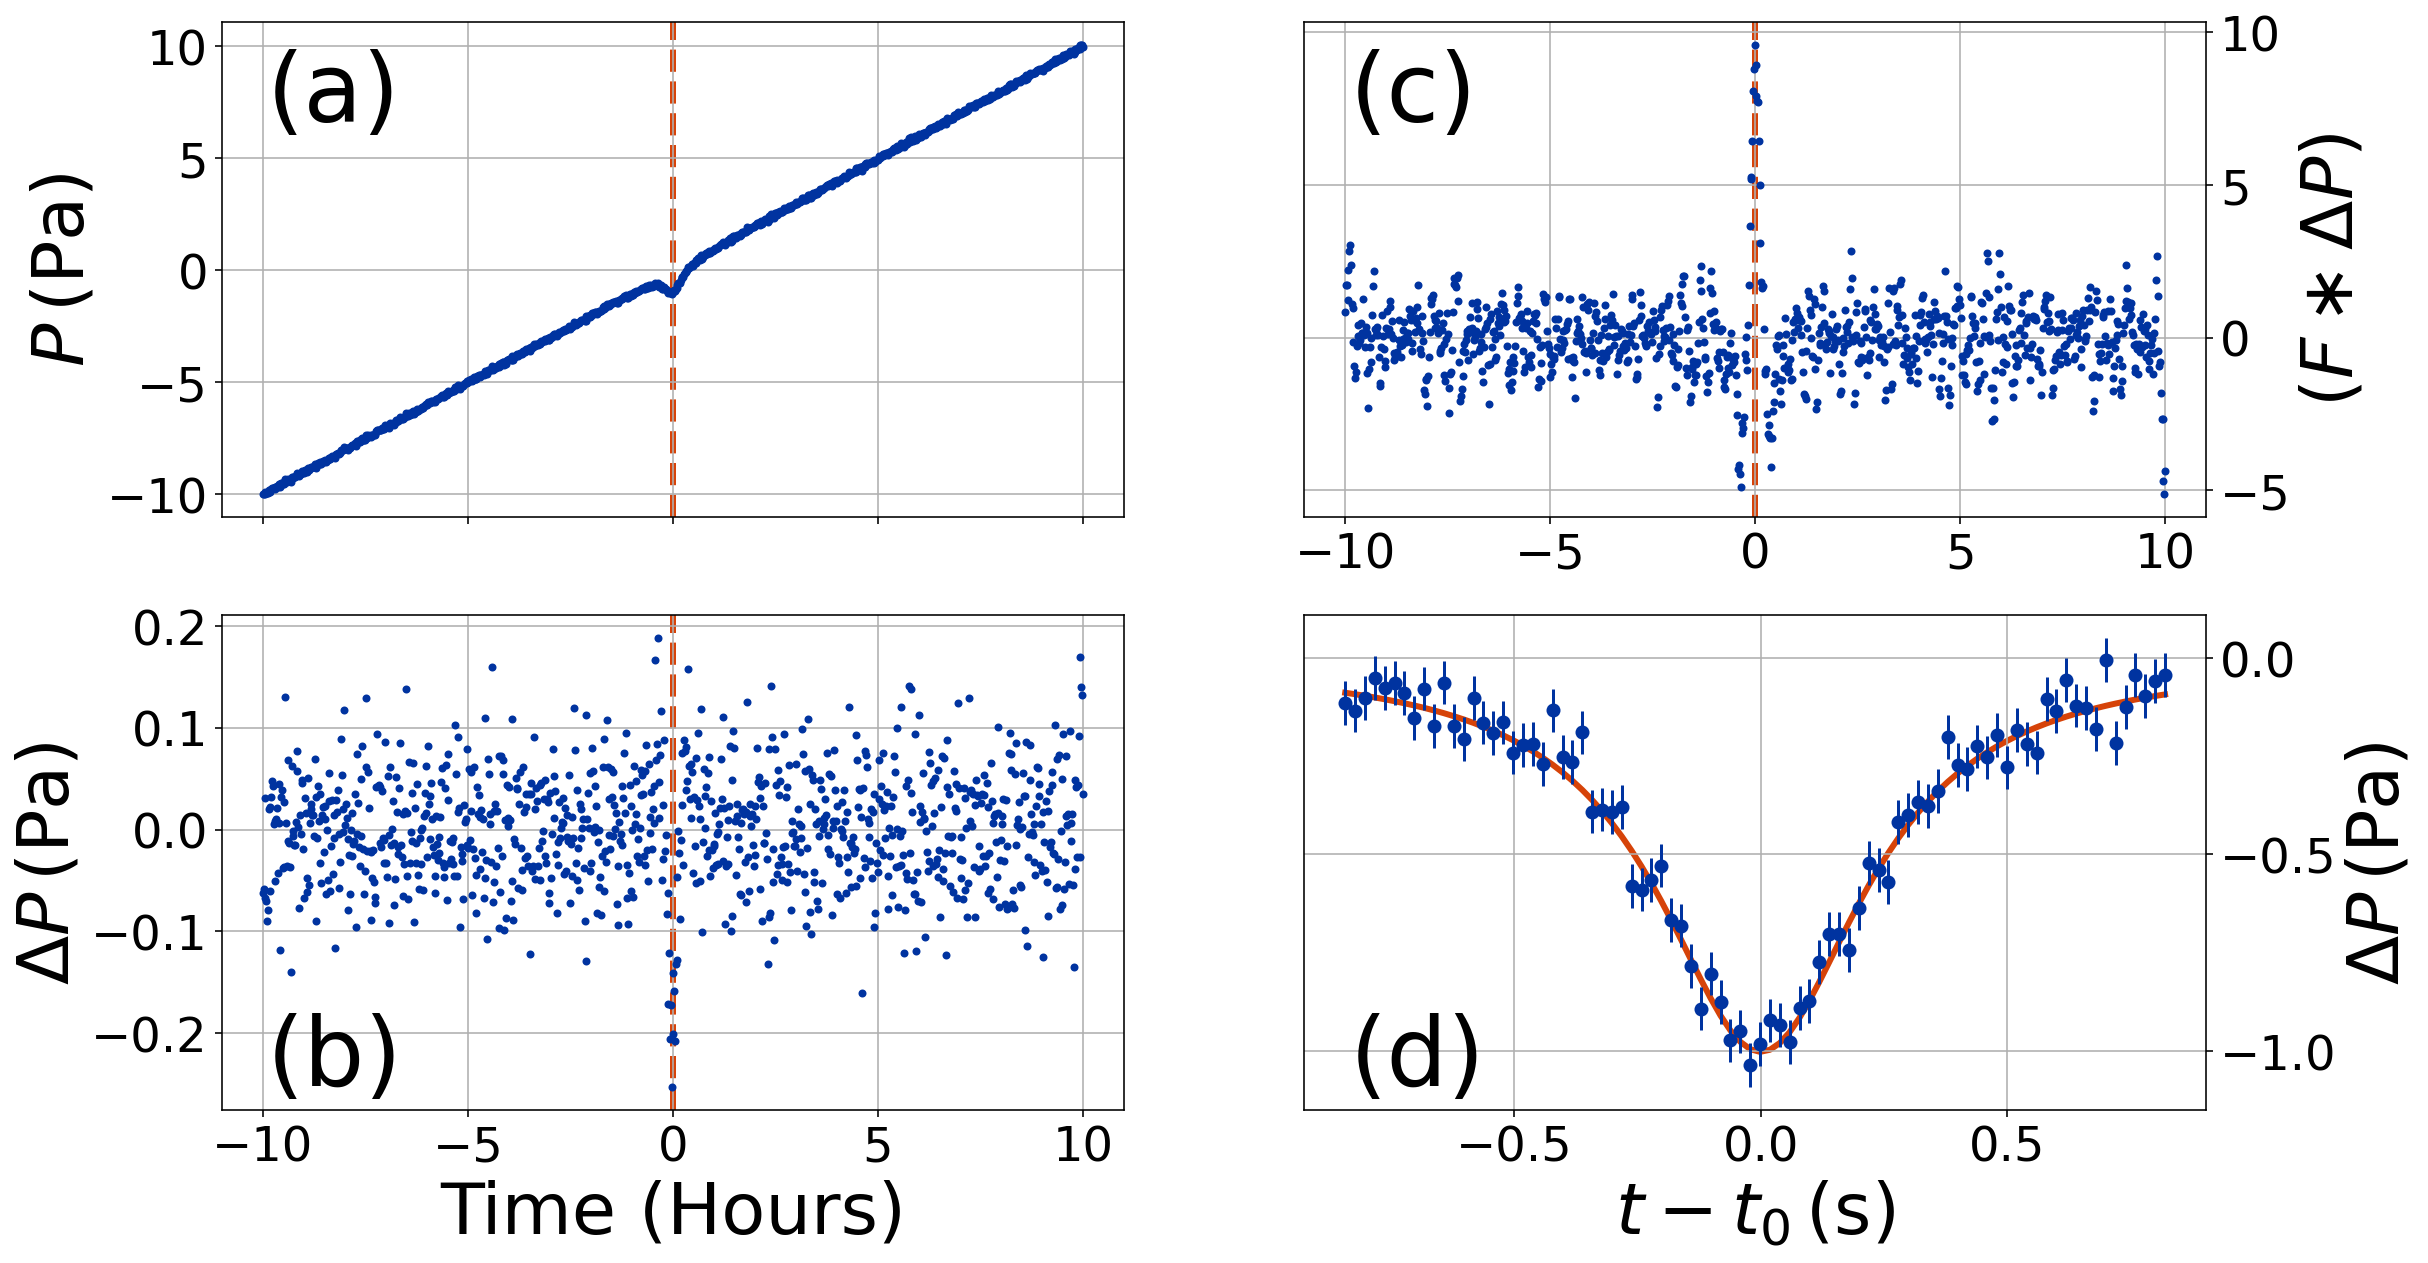

In [13]:
# Make plot showing how the data are conditioned and write out the data in each panel
mt.make_conditioned_data_figure(write_filename="./test_");